# Train Diffusion Model
### Imports

In [1]:
#!pip install librosa
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))
# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import *

### Conf

In [2]:
remote_kernel: bool = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name: str = "diffusion_v3"
training_data_name: str = "training_full_low_res"
model_path: str = path_to_remote_path(f"{MODEL_PATH}/{model_name}.pth", remote_kernel)
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

In [3]:
diffusion_timesteps: int = 500
n_starting_filters: int = 24
n_downsamples: int = 3
time_embed_dim: int = 128
n_starting_attention_size: int = 32

### Functions

In [4]:
def bwd_pass(model: Diffusion, n_samples: int = 1, file_name: str = "test") -> None:
    x: ndarray = model.bwd_diffusion(n_samples=n_samples)
    print(x[0,0].shape)
    for i in range(x.shape[0]):
        visualize_spectogram(x[i, 0])
        audio = spectrogram_to_audio(unnormalize(x[i, 0]), LEN_FFT)
        save_audio_file(audio, path_to_remote_path(f"{RESULT_PATH}/{file_name}_{i:02d}_out.wav", remote_kernel))
    logger.light_debug(f"Saved passed through samples to {RESULT_PATH}")

### Data Loading & Model Creation

In [5]:
file = load_training_data(path_to_remote_path(f"{DATA_PATH}/{training_data_name}.npy", remote_kernel))[:100,...]
logger.info(f"Data loaded with shape: {file.shape}")

u_net = Conv_U_NET(in_channels=1, time_embed_dim=time_embed_dim, n_starting_filters=n_starting_filters, n_downsamples=n_downsamples, activation=nn.GELU(), device=device)
u_net.load_state_dict(torch.load(model_path, weights_only=False, map_location=device))
logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")


u_net = u_net.to(device)

model = Diffusion(model=u_net, noise_steps=diffusion_timesteps, noise_schedule="linear", input_dim=[8, 1, file.shape[-2], file.shape[-1]], device=device)


2025-03-06 20:01:20,268 - INFO - Data loaded with shape: (100, 224, 416)
2025-03-06 20:01:25,181 - INFO - Model diffusion_v3 loaded with 9743665 Parameters


### Evaluate

In [6]:
#bwd_pass(model, n_samples=8, file_name="test")
x: ndarray = model.bwd_diffusion(n_samples=8)

2025-03-06 20:01:25,299 - INFO - Started sampling 8 samples


Step 490:
  alpha_t: 0.980319
  alpha_hat_t: 0.007459
  beta_t: 0.019681
  pred_noise mean/std: -0.000, 0.898
  pred_noise min/max: -4.317, 4.761
  x min/max: -4.912, 4.990
Step 480:
  alpha_t: 0.980718
  alpha_hat_t: 0.009082
  beta_t: 0.019282
  pred_noise mean/std: 0.004, 0.881
  pred_noise min/max: -4.041, 5.011
  x min/max: -5.002, 4.998
Step 470:
  alpha_t: 0.981117
  alpha_hat_t: 0.011014
  beta_t: 0.018883
  pred_noise mean/std: 0.006, 0.873
  pred_noise min/max: -4.335, 4.370
  x min/max: -5.249, 5.405
Step 460:
  alpha_t: 0.981515
  alpha_hat_t: 0.013303
  beta_t: 0.018485
  pred_noise mean/std: 0.001, 0.862
  pred_noise min/max: -4.416, 4.128
  x min/max: -5.869, 5.868
Step 450:
  alpha_t: 0.981914
  alpha_hat_t: 0.016002
  beta_t: 0.018086
  pred_noise mean/std: 0.005, 0.855
  pred_noise min/max: -4.227, 4.001
  x min/max: -7.503, 6.477
Step 440:
  alpha_t: 0.982313
  alpha_hat_t: 0.019171
  beta_t: 0.017687
  pred_noise mean/std: 0.007, 0.846
  pred_noise min/max: -4.101, 

2025-03-06 20:02:26,258 - INFO - Created 8 samples


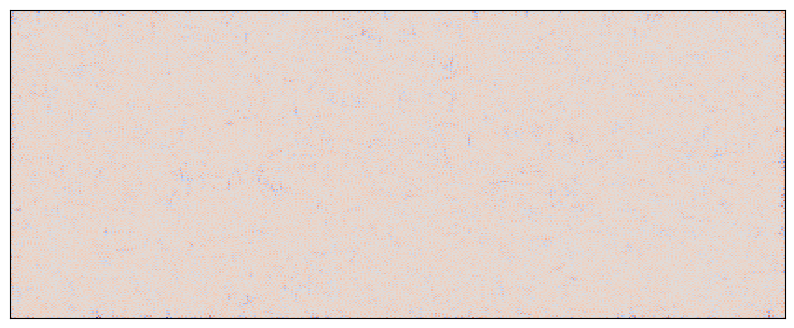

In [9]:
#model.visualize_diffusion_steps(torch.tensor(file[:1]), 10)
visualize_spectogram(x[0,0])

### Save Model Architecture

In [8]:
u_net.eval()
with torch.no_grad():
    u_net.eval()
with torch.no_grad():
    example_x = torch.randn(8, 1, file.shape[-2], file.shape[-1]).to(device)
    example_t = torch.randint(0, 500, (8,), dtype=torch.long).to(device)

    script_model = torch.jit.trace(u_net,(example_x, example_t), check_trace=False)
torch.jit.save(script_model, path_to_remote_path(f"{RESULT_PATH}/{model_name}.pt", remote_kernel))
#torchviz.make_dot(model(torch.randn(BATCH_SIZE, 1, file.shape[-2], file.shape[-1])), params=dict(model.named_parameters())).render(f"{RESULT_PATH}/{model_name}", format="png") #Not working
#logger.info(f"Saved model {path_to_remote_path(f"{RESULT_PATH}/{model_name}.pt", remote_kernel)}")